<a href="https://colab.research.google.com/github/isfandyar/HTV21/blob/main/DCP_toUpperCompute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#toUppercase Distributed Job Example on DCP 
### Distributed capitalization of a string!
Last Updated: July 22, 2021

In this collab, we will use the Distributed Compute Protocol (DCP) to split up a string, send one letter to many computers to be capitalized, and collect an uppercase string back. Of course, it's a trivial job merely meant to demonstrate how to write distributed jobs with DCP.

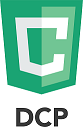

## DCP Overview

**Summary**: DCP is an easy-to-use, powerful parallel computing framework that allows users to express a computational **job** as easily as:

`job = compute.for(inputSet, workFunction)`

`resultSet = await job.exec()`

where the `workFunction` is maped onto each element in the `inputSet`. Each maping represents a **slice**. Slices are automatically distributed across DCP networks for computation, and results are automatically returned to the user in the correct order. Said otherwise, imagine writing a parallel *for loop* in which loop elements are independently calculated (no recursion), but instead of executing that loop with your laptop, you're simultaneously executing it with hundreds or thousands of laptops, computers, servers.

DCP also allows users to create their own computing networks with arbitrary computers and devices. **Public** DCP network: earn compute Credits when executing work, spend Credits when deploying work (sharing economy). **Private** DCP networks: create your own network with computers and devices lying around and use it as much as you want (contact us to get private compute group credentials).

1. Go to https://dcp.work on as many devices as you want and click `Start` to join the public compute group, or to `dcp.work/<computeGroupName>` if you have a private compute group `joinKey` and `joinSecret`.
2. Configure environment: load `dcp-client` and any required packages.
3. Specify the `inputSet`: an arbitrary, but enumerable input dataset (parameters, mp3 files, images, blender project file, etc)
4. Specify the `workFunction`: an arbitrary work function (physics simulation, inference model, rendering process, etc)
5. Express the `job`: Map the workFunction onto the inputSet with `job = compute.for(inputSet, workFunction)`
6. (optional) Specify a compute group with `job.computeGroups=[{joinKey: '<name>', joinSecret: '<password>'}]`
7. Await the `resultSet`: Execute the job in parallel on DCP via `resultSet = await job.exec()`

## Configure Node.js and DCP Enviornment
First, let's set up our `node.js` environment to work within this notebook.  Run the code blocks below to initialize node, npm.

In [1]:
%%capture
!npm install -g n && n 10.20.1
!pip install git+https://github.com/Kings-Distributed-Systems/Bifrost@interface

from bifrost import node, npm

## DCP Client & Compute API
Next, we need to require `dcp-client` library, and the `Compute API`.  These packages will allow us to access the `Distributed Compute Protocol` and send our job to computers and devices available on the network. 

In [ ]:
%%capture

# Installs dcp-client using the notebook's node.js backend
npm.install('dcp-client')

In [ ]:
%%node

// Requires dcp-client 
require('dcp-client').initSync();
const compute = require('dcp/compute');

## DCP Account
Running the example will require a DCP account keystore, which can be done [here](https://portal.distributed.computer). Download it, then browse to it so we can use it for this notebook.

In [ ]:
# Loads a DCP Account keystore containing compute Credits
# When prompted, please upload your keystore file

from google.colab import files

KEYSTORE_NAME = list(files.upload().keys())[0]

!mkdir -p ~/.dcp
!cp /content/$KEYSTORE_NAME ~/.dcp/default.keystore
!cp /content/$KEYSTORE_NAME ~/.dcp/id.keystore


Saving default.keystore to default.keystore


## Input Data
Now we will set up our input data. For this example, enter any string in the field below.  We will split it into its characters, and prepare to distribute them.

In [ ]:
#@markdown ### Enter String to Capitalize
inputString = "" #@param {type:"string"}

In [ ]:
%%node

inputSet = Array.from(inputString);
console.log("Input generated");

Input generated


## Work Function
This is the function that each worker will run in parallel.  We are going to send each worker one character from the input string. It will then return the character in uppercase.

The function `progress()` must be called every ~30 seconds so that the worker knows that the job is not stuck. (For this example, calling it once should suffice).

In [ ]:
%%node

 async function workFn(letter) {
    progress();
    return letter.toUpperCase();
}

## Compute For
Now let's set up our compute job.  We will pass it the input array. Unless range/iteration arguments are given, compute.for(input, workFn) will send each input array element to different worker sandboxes to be computed with the work function.  Then we will assign a public name for the job.

Here, if you would like to use a `compute group`, enter your `joinKey` and `joinSecret`, otherwise, your job will use the public network. 

In [ ]:
#@markdown ### Private Compute Group ( *Optional* )

#@markdown Name of private compute group
join_key = 'hackathon' #@param {type:"string"}
#@markdown Password for private compute group
join_secret = 'dcp2021' #@param {type: "string"}



In [ ]:
%%node

async function deploy(input) {
  let job = compute.for(input, workFn);
  job.public.name = 'DCP - toUpperCompute';

  if (join_key) job.computeGroups = [{joinKey: join_key, joinSecret: join_secret}];
  

  job.on('accepted', () => {
    console.log(` - Job accepted by scheduler, waiting for results`);
    console.log(` - Job has id ${job.id}`);
  });

  job.on('result', (ev) => {
    //console.log(ev.result);   
  });

  let results = await job.exec();
  console.log("Compute complete");
  return Array.from(results);
}

resultSet = deploy(inputSet).then((value) => {
      console.log(value.join(''));
});

- Job accepted by scheduler, waiting for results
- Job has id 0x8AE90CfF9eaEb6F482CBe930F29e9FfF70DF7e8B
Compute complete
QMIND SHOULD BE CAPITAL!


## Get Results


Now let's take a look at our output data.

In [ ]:
%%node
console.log(resultSet.join(''));

Error occured during script running/parsing:  evalmachine.<anonymous>:1
console.log(resultSet.join(''));
^
TypeError: resultSet.join is not a function
at evalmachine.<anonymous>:1:23
at Script.runInContext (vm.js:133:20)
at Object.runInContext (vm.js:311:6)
at Evaluator.evaluate (/usr/local/lib/python3.7/dist-packages/bifrost/main.js:167:18)
at Transform.inputStream._transform (/usr/local/lib/python3.7/dist-packages/bifrost/main.js:190:25)
at Transform._read (_stream_transform.js:190:10)
at Transform._write (_stream_transform.js:178:12)
at doWrite (_stream_writable.js:415:12)
at writeOrBuffer (_stream_writable.js:399:5)
at Transform.Writable.write (_stream_writable.js:299:11)


Oh boy, uppercase! Each one of those letters was converted to uppercase by a different worker sandbox. Now that we're finished with this simple example, imagine what other parrelelizable tasks DCP could be used for. From video rendering to smart manufacturing - the possibilities are endless. For example, check out this Colab file doing [Hyperparameter Tuning on DCP](https://colab.research.google.com/drive/1gGFeDNH0bYTu_1MkXM6K0zLzmCQU7t9o?usp=sharing)

Here is the same simple demo in a web development environment: https://jsfiddle.net/DCP_team/f26dzbwr/

